# Model prototyping
This notebook introduces a prototype for the DAN architecture and performs some basic experiments using synthetic data to assess and visualize the model's behavior.

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import tensorflow as tf

from matplotlib import rcParams
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score, \
    f1_score, roc_auc_score, classification_report, confusion_matrix
from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set(context='poster', style='whitegrid')

# User-defined settings

In [3]:
# Dimensionality of the synthetic data. 2 allows for easy visualization
NUM_FEATURES = 2

# Number of samples in each class
NUM_NEGATIVES = 90000
NUM_POSITIVES = 10000

# Number of times a given model type is trained and evaluated
# Allows us to get a distribution of accuracy scores
NUM_EXPERIMENTS = 20 

# Generate synthetic data
We first create an imbalanced synthetic dataset by sampling negative and positive examples from different Gaussian distributions.

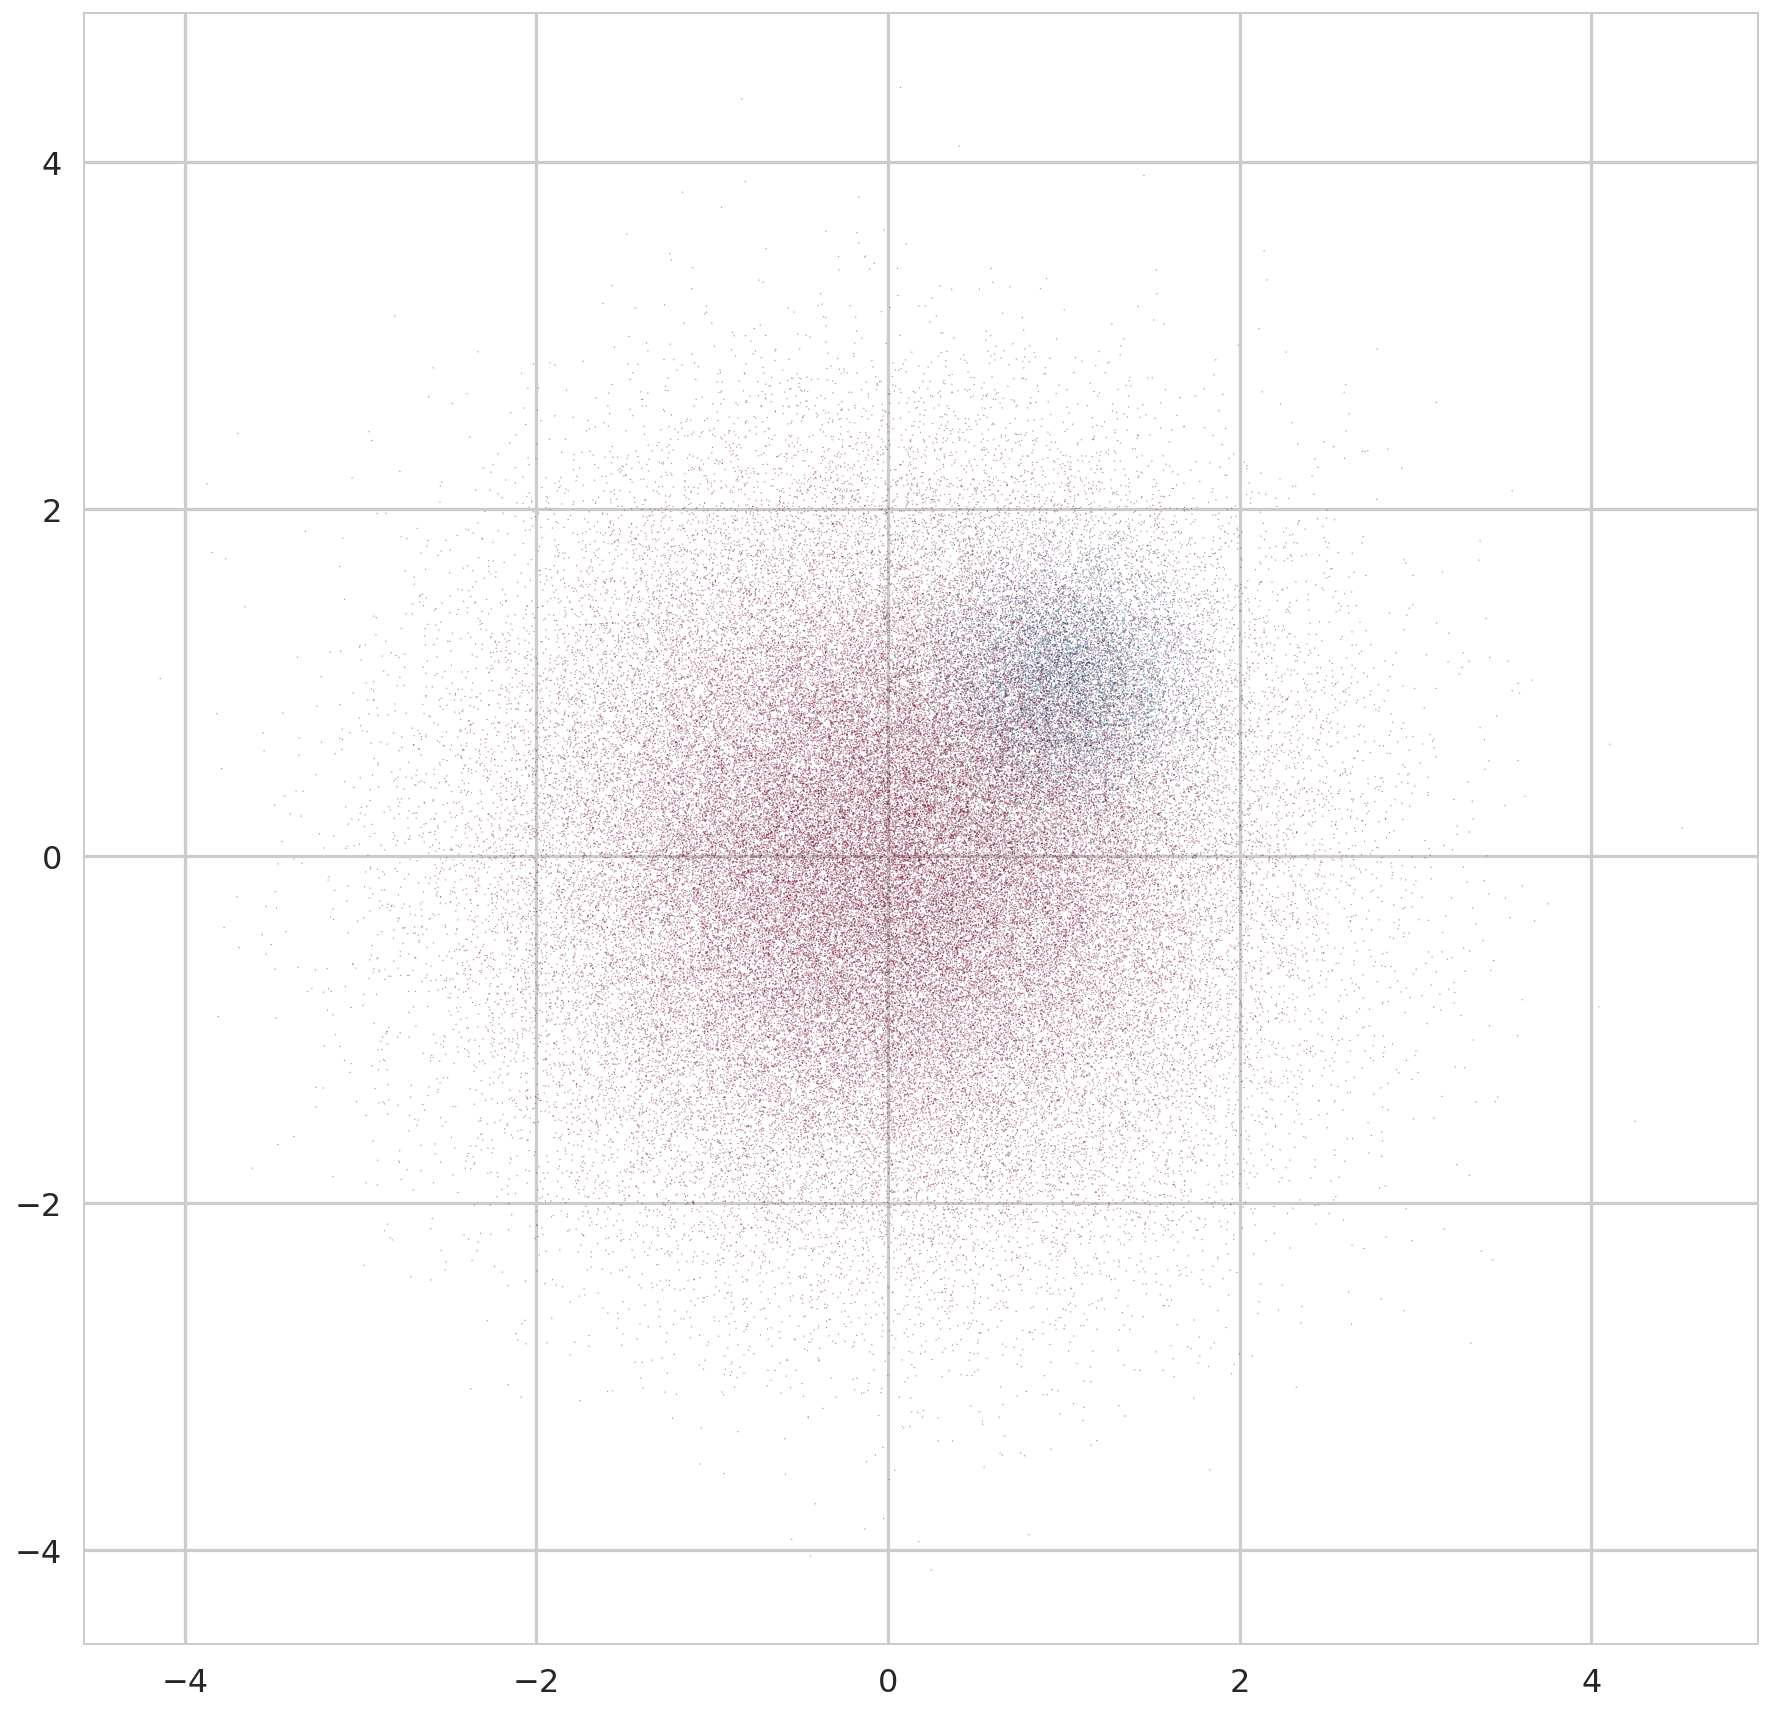

In [4]:
# Make positives/negative samples and combine
X_negatives = np.random.normal(
  loc=[0]*NUM_FEATURES, scale=[1]*NUM_FEATURES, 
  size=[NUM_NEGATIVES, NUM_FEATURES])
X_positives = np.random.normal(
  loc=[1]*NUM_FEATURES, scale=[0.4]*NUM_FEATURES,
  size=[NUM_POSITIVES, NUM_FEATURES])
X = np.vstack([X_negatives, X_positives])

# Generate labels and one-hot encode them
y = np.array([0] * NUM_NEGATIVES + [1] * NUM_POSITIVES)
y = pd.get_dummies(y).values

# Randomly shuffle samples and labels
shuffled_indices = np.random.permutation(range(len(X)))
X = X[shuffled_indices]
y = y[shuffled_indices]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, stratify=y[:,1])

# Visualize distributions to ensure data was generated correctly
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(X[:,0], X[:,1], s=0.01, c=y[:,1], cmap='RdBu')

# Helper functions

In [5]:
def evaluate_performance(y, y_pred_probas):
  """
  Prints a variety of performance metrics and visualizes the distribution
  of predicted positive probabilities.
  
  Parameters
  ==========
  y : numpy array, shape = (num_samples, 2)
    A one-hot encoding of the true classes each sample belongs to. First column
    indicates membership in negative class, second column indicates membership
    in positive class.
  y_pred_probas : numpy array, shape = (num_samples, 2)
    The predicted probabilities output by a model. First column contains
    probabilities samples are negative, second column contains probabilities
    samples are positive.
  """
  
  y = y[:, 1]
  y_pred_probas = y_pred_probas[:, 1]
  y_pred = y_pred_probas >= 0.5
  
  print('ACCURACY: {:.4f}'.format(accuracy_score(y, y_pred)))
  print('AUROC: {:.4f}'.format(roc_auc_score(y, y_pred_probas)))
  print('AVG PRECISION: {:.4f}'.format(average_precision_score(y, y_pred_probas)))
  
  # Print a normalized confusion matrix using proportions rather than counts
  print('CONFUSION MATRIX')
  print(confusion_matrix(y, y_pred) / len(y))
  print('CLASSIFICATION REPORT')
  print(classification_report(y, y_pred))
  
  # Visualize distribution of positive prediction probabilities
  ax = plt.gca()
  ax.hist(y_pred_probas, bins=20)
  ax.set_xlim(0, 1)
  plt.show()

# Estimate Bayes' optimal error
Because the synthetic data is generated from Gaussian distributions, the Gaussian Naive Bayes model should be the best model for classifying this data and provide a close estimate of Bayes' optimal error. This error will give us an idea of the upper bound of classification accuracy any model can hope to achieve. However, Bayes' error does not give any indication about the upper bound of AUROC.

ACCURACY: 0.9184
AUROC: 0.9497
AVG PRECISION: 0.5884
CONFUSION MATRIX
[[0.863525 0.036475]
 [0.045075 0.054925]]
CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.95      0.96      0.95     72000
          1       0.60      0.55      0.57      8000

avg / total       0.92      0.92      0.92     80000



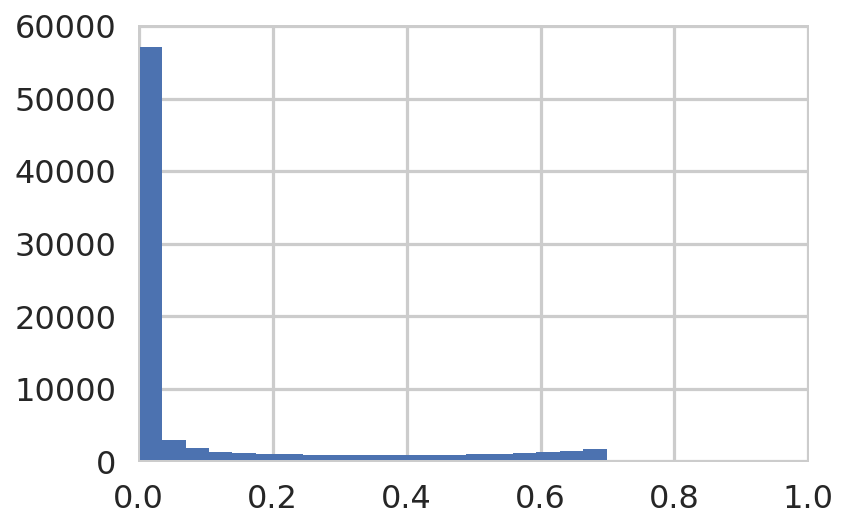

ACCURACY: 0.9140
AUROC: 0.9472
AVG PRECISION: 0.5685
CONFUSION MATRIX
[[0.86035 0.03965]
 [0.04635 0.05365]]
CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.95      0.96      0.95     18000
          1       0.58      0.54      0.56      2000

avg / total       0.91      0.91      0.91     20000



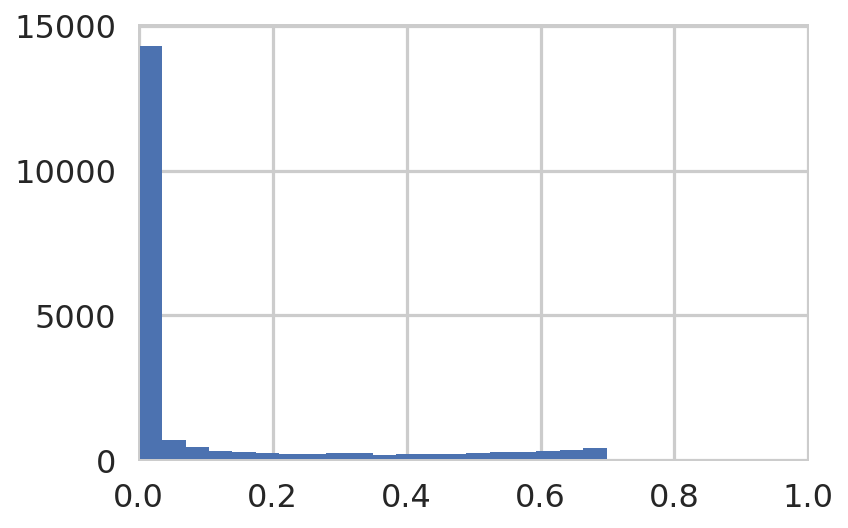

In [6]:
nb = GaussianNB(priors=[0.9, 0.1])
nb.fit(X_train, y_train[:, 1])

y_train_pred = nb.predict_proba(X_train)
y_test_pred = nb.predict_proba(X_test)

# Print metrics for both train and test to ensure no overfitting
evaluate_performance(y_train, y_train_pred)
evaluate_performance(y_test, y_test_pred)

# Generate a baseline using Keras
We define a simple baseline neural network model in Keras. This will give us an understanding of how far-off an ANN's accuracy is from optimal and provides a reference accuracy for checking that the discriminator network of the DAN was constructed correctly.

In [9]:
def make_baseline_model():
  baseline_model = Sequential([
    Dense(4, input_dim=2, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='softmax'),
  ])
  baseline_model.compile(
    optimizer=Adam(lr=1e-2),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )
  return baseline_model

def model_accuracy(model, X, y):
  y_pred_probas = model.predict(X)
  y_pred = y_pred_probas >= 0.5
  return accuracy_score(y[:,1], y_pred[:,1])

def model_auroc(model, X, y):
    y_pred_probas = model.predict(X)
    return roc_auc_score(y[:,1], y_pred_probas[:,1])

In [14]:
# Collects metrics from each experiment
baseline_accuracies = list()
baseline_aurocs = list()

for experiment in range(NUM_EXPERIMENTS):
  baseline_model = make_baseline_model()
  baseline_model.fit(
    X_train, y_train, epochs=20, verbose=False, batch_size=512)
  
  accuracy = model_accuracy(baseline_model, X_test, y_test)
  auroc = model_auroc(baseline_model, X_test, y_test)
  
  baseline_accuracies.append(accuracy)
  baseline_aurocs.append(auroc)

Mean validation accuracy: 0.912655
Mean validation AUROC: 0.9453248736111108


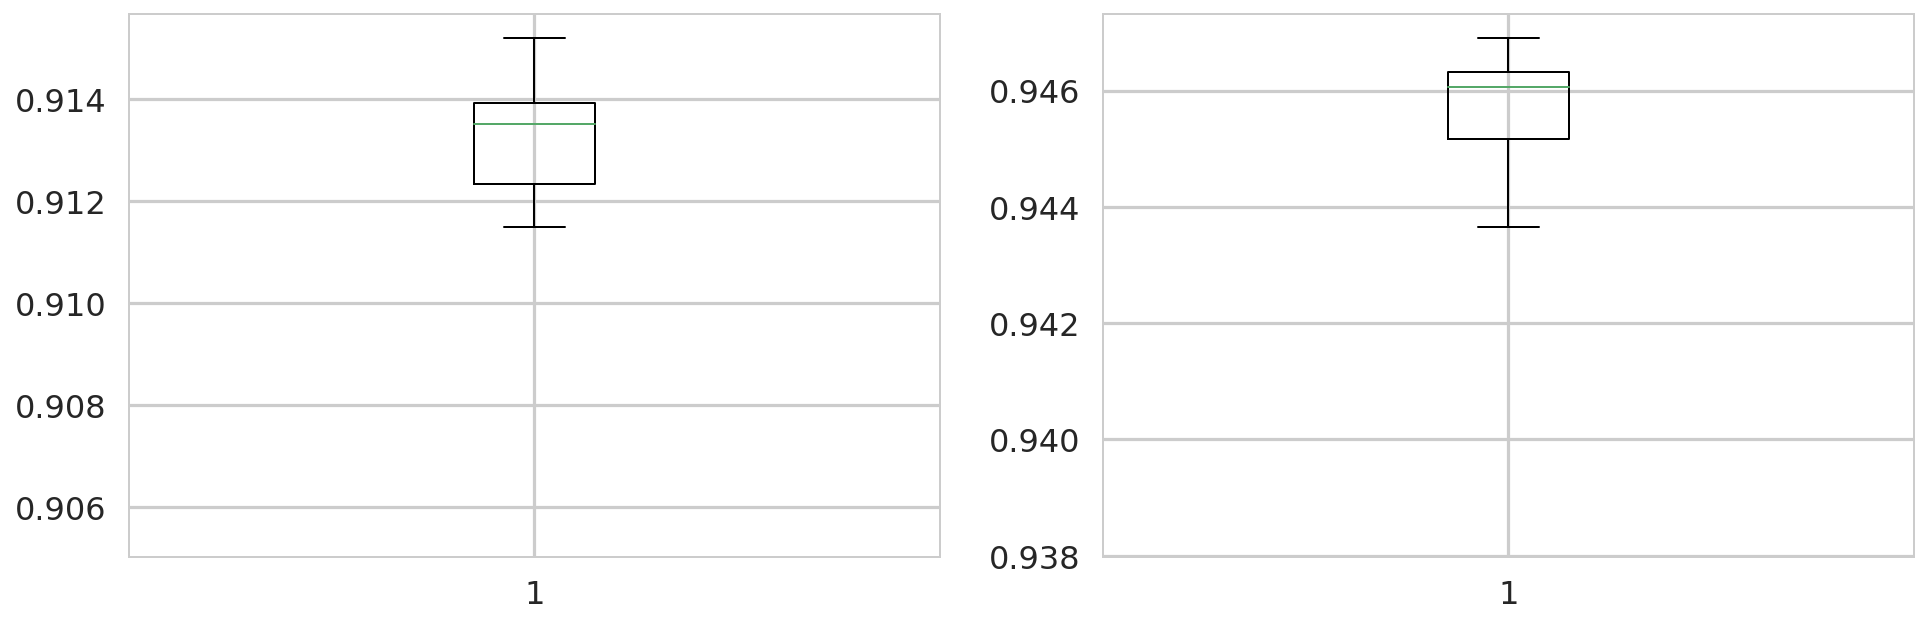

In [15]:
print('Mean validation accuracy: {}'.format(np.mean(baseline_accuracies)))
print('Mean validation AUROC: {}'.format(np.mean(baseline_aurocs)))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].boxplot(baseline_accuracies)
axes[1].boxplot(baseline_aurocs);

Visualize training loss for a single model and check for overfitting.

In [17]:
baseline_model = make_baseline_model()
history = baseline_model.fit(
  X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=False,
  batch_size=512,
)

(0, 0.4)

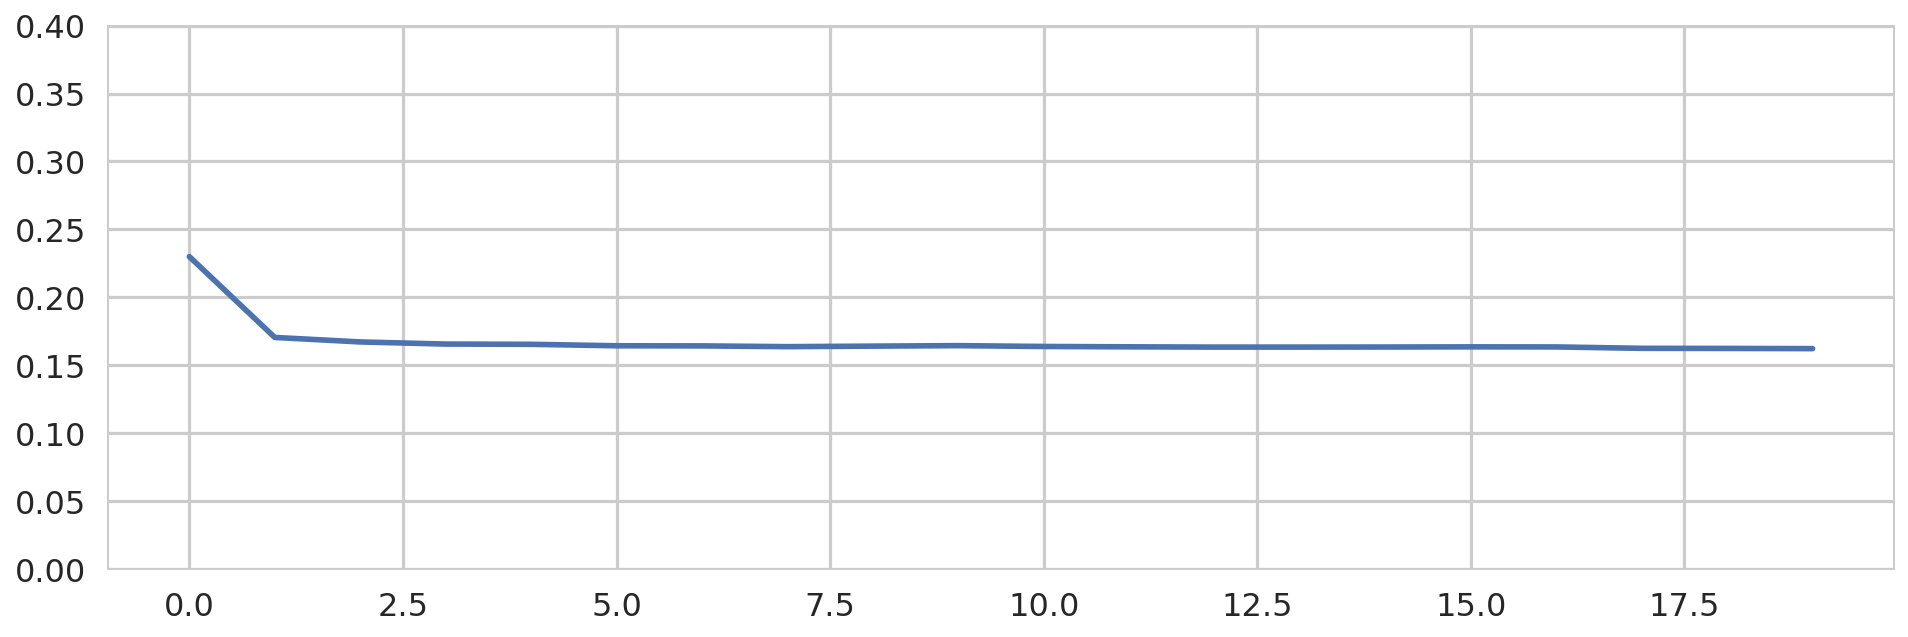

In [18]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'])
plt.ylim(0, 0.4)

ACCURACY: 0.9178
AUROC: 0.9493
AVG PRECISION: 0.5856
CONFUSION MATRIX
[[0.868925 0.031075]
 [0.0511   0.0489  ]]
CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.94      0.97      0.95     72000
          1       0.61      0.49      0.54      8000

avg / total       0.91      0.92      0.91     80000



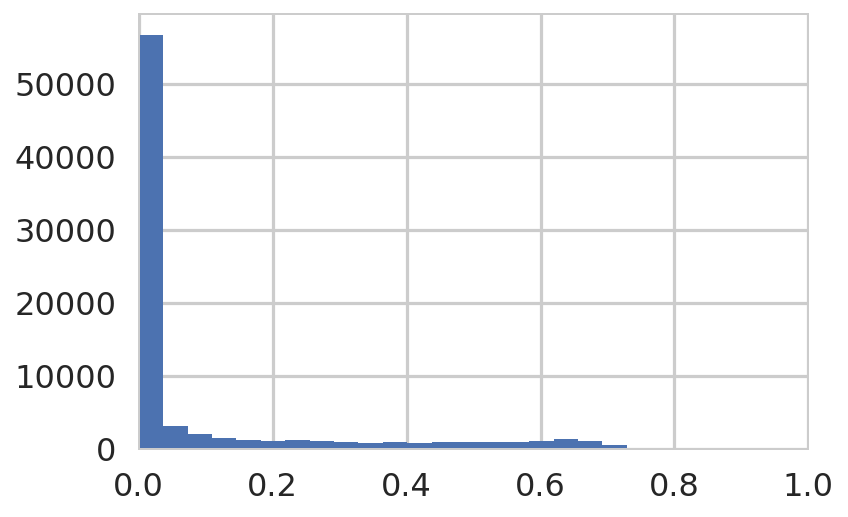

ACCURACY: 0.9139
AUROC: 0.9466
AVG PRECISION: 0.5647
CONFUSION MATRIX
[[0.8662  0.0338 ]
 [0.05235 0.04765]]
CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.94      0.96      0.95     18000
          1       0.59      0.48      0.53      2000

avg / total       0.91      0.91      0.91     20000



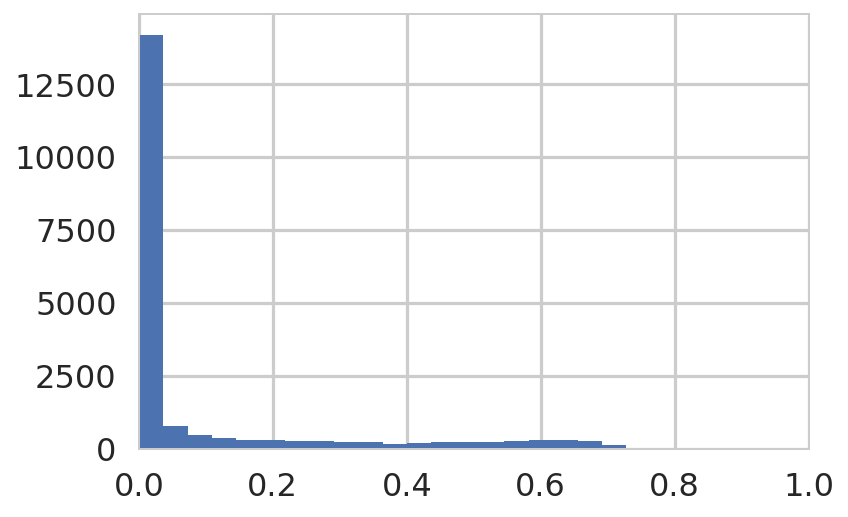

In [19]:
# Evaluate performance on test data
y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)

evaluate_performance(y_train, y_train_pred)
evaluate_performance(y_test, y_test_pred)

# Define Disguise Adversarial Network

In [20]:
class DAN:
    
  def __init__(
    self, checkpoint_dir, num_features,
    lambd=1, eta=1, learning_rate=1e-3):
    """
    Disguise Adversarial Network
    
    Parameters
    ==========
    checkpoint_dir : str
      The path to the directory where checkpoints are saved and loaded.
    num_features : int
      The dimensionality of the dataset, i.e. the number of input features.
    lambd : float
      The amount of regularization applied in the disguise network loss.
      Larger values restrict the diguise network from applying drastic
      transformations on negative samples.
    eta : float
      Controls the contribution of the predictive entropy of disguised
      samples to the entire discriminator loss.
    learning_rate : float
      The learning rate of the optimizer.
    """
    
    self.checkpoint_dir = checkpoint_dir
    self.num_features = num_features
    self.lambd = lambd
    self.eta = eta
    self.learning_rate = learning_rate
    self.best_score = 0
    
    with tf.variable_scope('dan'):
      self._create_network()
      self._create_losses()
      self._create_optimizers()
      
    self.sess = tf.Session()
    self.sess.run(tf.global_variables_initializer())
    self.loaded = self._load_checkpoints()
    
    # Collect various training losses
    # Eventually replace with tensorboard functionality
    keys = ['disguise_loss', 'discriminator_loss', 'cross_entropy']
    self.history = {key: list() for key in keys}
    
  def _load_checkpoints(self):
    """
    Checks if a model checkpoint exists, and if so, alters 'self.sess' to
    reflect the appropriate state of the Tensorflow computation graph.
    """
    self.saver = tf.train.Saver()
    checkpoint = tf.train.get_checkpoint_state(self.checkpoint_dir)
  
    # If checkpoint exists and is reachable, load checkpoint state into 'sess'
    if checkpoint and checkpoint.model_checkpoint_path:
      self.saver.restore(self.sess, checkpoint.model_checkpoint_path)
      print('loaded checkpoint: {}'.format(checkpoint.model_checkpoint_path))
      return True
    else:
      print(
        'Could not find old checkpoint. Creating new checkpoint directory.')
      if not os.path.exists(self.checkpoint_dir):
        os.mkdir(self.checkpoint_dir)
      return False
        
  # TODO: refactor as its own callable class for easier customizability
  def _create_disguise_network(self, x):
    """
    Defines the graph for the disguise network.
    
    Parameters
    ==========
    x : tensor, shape = (num_negatives_in_batch, num_features)
      All negative samples in the current mini-batch.
    
    Returns
    =======
    disguised : tensor, shape = (num_netaives_in_batch, num_features)
      All negative samples in the current mini-batch disguised as 
      positive samples.
    """
    with tf.variable_scope('disguise', reuse=tf.AUTO_REUSE):
      x = tf.layers.Dense(8, activation=tf.nn.elu)(x)
      x = tf.layers.Dense(6, activation=tf.nn.elu)(x)
      x = tf.layers.Dense(4, activation=tf.nn.elu)(x)
      disguised = tf.layers.Dense(2, name='disguised')(x)
      return disguised
  
  # TODO: refactor as its own callable class for easier customizability
  def _create_discriminator_network(self, x):
    """
    Defines the graph for the discriminator network.
    
    Parameters
    ==========
    x : tensor, shape = (num_samples, num_features)
      Negative and positive samples or disguised samples.
    
    Returns
    =======
    logits : tensor, shape = (num_samples, 2)
      Output of the final discriminator layer with no activation applied.
    """
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
      x = tf.layers.Dense(4, activation=tf.nn.relu)(x)
      x = tf.layers.Dense(4, activation=tf.nn.relu)(x)
      logits = tf.layers.Dense(2, name='logits')(x)
      return logits
    
  def _create_network(self):
    """
    Defines the graph for the entire DAN.
    """
    
    # Tensors whose values will be provided during execution
    self.x_input = tf.placeholder(
      dtype=tf.float32, shape=(None, self.num_features), name='x_input')
    self.y_input = tf.placeholder(
      dtype=tf.float32, shape=(None, 2), name='y_input')
    
    # Indices of negative samples in current mini-batch
    self.negative_indices = tf.placeholder(
      dtype=tf.int32, shape=(None,), name='negative_indices')
    
    # Filter for negative samples and disguise
    self.x_negatives = tf.gather(self.x_input, self.negative_indices)
    self.disguised = self._create_disguise_network(self.x_negatives)
    
    # Discriminator outputs for true samples
    self.labeled_logits = self._create_discriminator_network(self.x_input)
    self.labeled_preds = tf.nn.softmax(self.labeled_logits)
    
    # Discriminator outputs for disguised samples
    self.unlabeled_logits = self._create_discriminator_network(self.disguised)
    self.unlabeled_preds = tf.nn.softmax(self.unlabeled_logits)
    
  def _create_losses(self):
    """
    Defines discriminator and disguise loss functions and their respective
    components. tf.reduce_mean is applied to each component individually
    for ease of Tensorboard monitoring.
    """
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(
      labels=self.y_input, logits=self.labeled_logits)
    self.cross_entropy = tf.reduce_mean(cross_entropy)
    
    # TODO: confirm this actually returns entropy when used this way
    predictive_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(
      labels=self.unlabeled_preds, logits=self.unlabeled_logits)
    self.predictive_entropy = tf.reduce_mean(predictive_entropy)
    
    self.discriminator_loss = self.cross_entropy + self.eta * self.predictive_entropy
    
    # The disguise loss is defined only on positive prediction probabilities
    unlabeled_preds_temp = tf.gather(self.unlabeled_preds, 1, axis=1)
    self.disguise_quality = tf.reduce_mean(tf.log(unlabeled_preds_temp))
    self.regularizer = tf.reduce_mean(
      tf.norm(self.disguised - self.x_negatives, ord=1))
    self.disguise_loss = -self.disguise_quality + self.lambd * self.regularizer
    
  def _create_optimizers(self):
    """
    Defines separate optimizers for the disguise and discriminator networks.
    Each network's optimizer should only update that network's weights despite
    the fact that each network's loss function partly depends on the weights
    of the other network.
    """
    optimizer = tf.train.AdamOptimizer
    
    disguise_weights = tf.get_collection(
      tf.GraphKeys.TRAINABLE_VARIABLES, 'dan/disguise')
    disguise_optimizer = optimizer(self.learning_rate)
    self.disguise_optimizer = disguise_optimizer.minimize(
      self.disguise_loss, var_list=disguise_weights)
    
    discriminator_weights = tf.get_collection(
      tf.GraphKeys.TRAINABLE_VARIABLES, 'dan/discriminator')
    discriminator_optimizer = optimizer(self.learning_rate)
    self.discriminator_optimizer = discriminator_optimizer.minimize(
      self.discriminator_loss, var_list=discriminator_weights)
    
    # This optimizer is only used when training the DAN without a disguise 
    # network (i.e. discriminator-only mode)
    cross_entropy_optimizer = optimizer(self.learning_rate)
    self.cross_entropy_optimizer = cross_entropy_optimizer.minimize(
      self.cross_entropy, var_list=discriminator_weights)
    
  def _partial_fit(self, batch_x, batch_y, disguise=True):
    """
    Trains the DAN on a mini-batch of data.
    
    Parameters
    ==========
    batch_x : numpy array, shape = (batch_size, num_features)
      A batch of training data.
    batch_y : numpy array, shape = (batch_size, 2)
      A batch of one-hot encoded labels.
    disguise : bool
      If true, the disguise network is trained along with the discriminator.
      Otherwise, the discriminator is optimized only on cross entropy, no
      different from a regular classifier.
    """
    negative_indices = np.argwhere(batch_y[:,0]).squeeze()
    feed_dict={
      self.x_input: batch_x,
      self.y_input: batch_y,
      self.negative_indices: negative_indices,
    }
    
    if disguise:
      results = self.sess.run([
        self.disguise_optimizer,
        self.discriminator_optimizer,
        self.disguise_loss,
        self.discriminator_loss,
        self.cross_entropy,
      ],
        feed_dict=feed_dict
      )
      _, _, disguise_loss, discriminator_loss, cross_entropy = results
      self.history['disguise_loss'].append(disguise_loss)
      self.history['discriminator_loss'].append(discriminator_loss)
      self.history['cross_entropy'].append(cross_entropy)
      
    else:
      results = self.sess.run([
        self.cross_entropy_optimizer,
        self.cross_entropy,
      ],
        feed_dict=feed_dict
      )
      _, cross_entropy = results
      self.history['cross_entropy'].append(cross_entropy)
    
  def fit(self, x, y, x_valid, y_valid, num_epochs=5, batch_size=256, disguise=True):
    """
    Fits the DAN on the entire training dataset.
    
    x : numpy array, shape = (num_samples, num_features)
      The features of the training set.
    y : numpy array, shape = (num_samples, 2)
      The one-hot encoded labels of the training set.
    num_epochs : int
      The number of times the model is fit on the whole training set.
    batch_size : int
      The number of samples in each mini-batch.
    disguise : bool
      If true, the disguise network is trained along with the discriminator.
      Otherwise, the discriminator is optimized only on cross entropy, no
      different from a regular classifier.
    """
    
    if self.loaded:
        y_valid_pred = self.predict(x_valid)
        self.best_score = roc_auc_score(y_valid, y_valid_pred)

    num_samples = len(y)
    num_batches = num_samples // batch_size
    
    for epoch in range(num_epochs):
      
      print('Training epoch {}...'.format(epoch))
      shuffled_indices = np.random.permutation(num_samples)
      x = x[shuffled_indices]
      y = y[shuffled_indices]
      
      start_index = 0
      end_index = batch_size
      
      for batch in range(num_batches+1):
        
        batch_x = x[start_index:end_index]
        batch_y = y[start_index:end_index]
        
        start_index += batch_size
        end_index += batch_size
        if end_index > num_samples:
          end_index = num_samples
          
        self._partial_fit(batch_x, batch_y, disguise)
      y_valid_pred = self.predict(x_valid)
      curr_score = roc_auc_score(y_valid, y_valid_pred)
      if self.best_score < curr_score:
        self.best_score = curr_score
        checkpoint = self.saver.save(self.sess, os.path.join(self.checkpoint_dir, 'model.ckpt'))
        print("Model saved to file: ", checkpoint)
      clear_output()

  # TODO: This will eventually need to support predicting in batches
  def predict(self, x):
    """
    Infers the class of the given samples.
    
    Parameters
    ==========
    x : numpy array, shape = (num_samples, num_features)
    
    Returns
    =======
    predictions : numpy array, shape = (num_samples, 2)
    """
    predictions = self.sess.run(self.labeled_preds, feed_dict={self.x_input: x})
    return predictions

  def transform(self, x_negatives):
    """
    Tranforms the given negative samples into disguised positives.
    
    Parameters
    ==========
    x_negatives : numpy array, shape = (num_samples, num_features)
    
    Returns
    =======
    disguised : numpy array, shape = (num_samples, num_features)
    """
    negative_indices = list(range(len(x_negatives)))
    disguised = self.sess.run(
      self.disguised, feed_dict={
        self.x_input: x_negatives,
        self.negative_indices: negative_indices}
    )
    return disguised

In [21]:
def make_dan():
  tf.reset_default_graph()
  dan = DAN(
    checkpoint_dir='../models/dz-prototype/', num_features=NUM_FEATURES,
    lambd=0.025, eta=0.2, learning_rate=1e-2)
  return dan

# Test discriminator-only performance
First we train a model exclusively with **disguise=False** so that the disguise network is not used at all. This merely serves as a check that the discriminator network trains and predicts as expected. Its performance should be comparable to the baseline model defined using Keras.

In [22]:
discriminator_accuracies = list()
discriminator_aurocs = list()
for experiment in range(NUM_EXPERIMENTS):
  dan = make_dan()
  dan.fit(
    X_train, y_train, num_epochs=20, batch_size=256, disguise=False)
  accuracy = model_accuracy(dan, X_test, y_test)
  auroc = model_auroc(dan, X_test, y_test)
  discriminator_accuracies.append(accuracy)
  discriminator_aurocs.append(auroc)

Mean validation accuracy: 0.9136024999999999
Mean validation AUROC: 0.9460526923611112


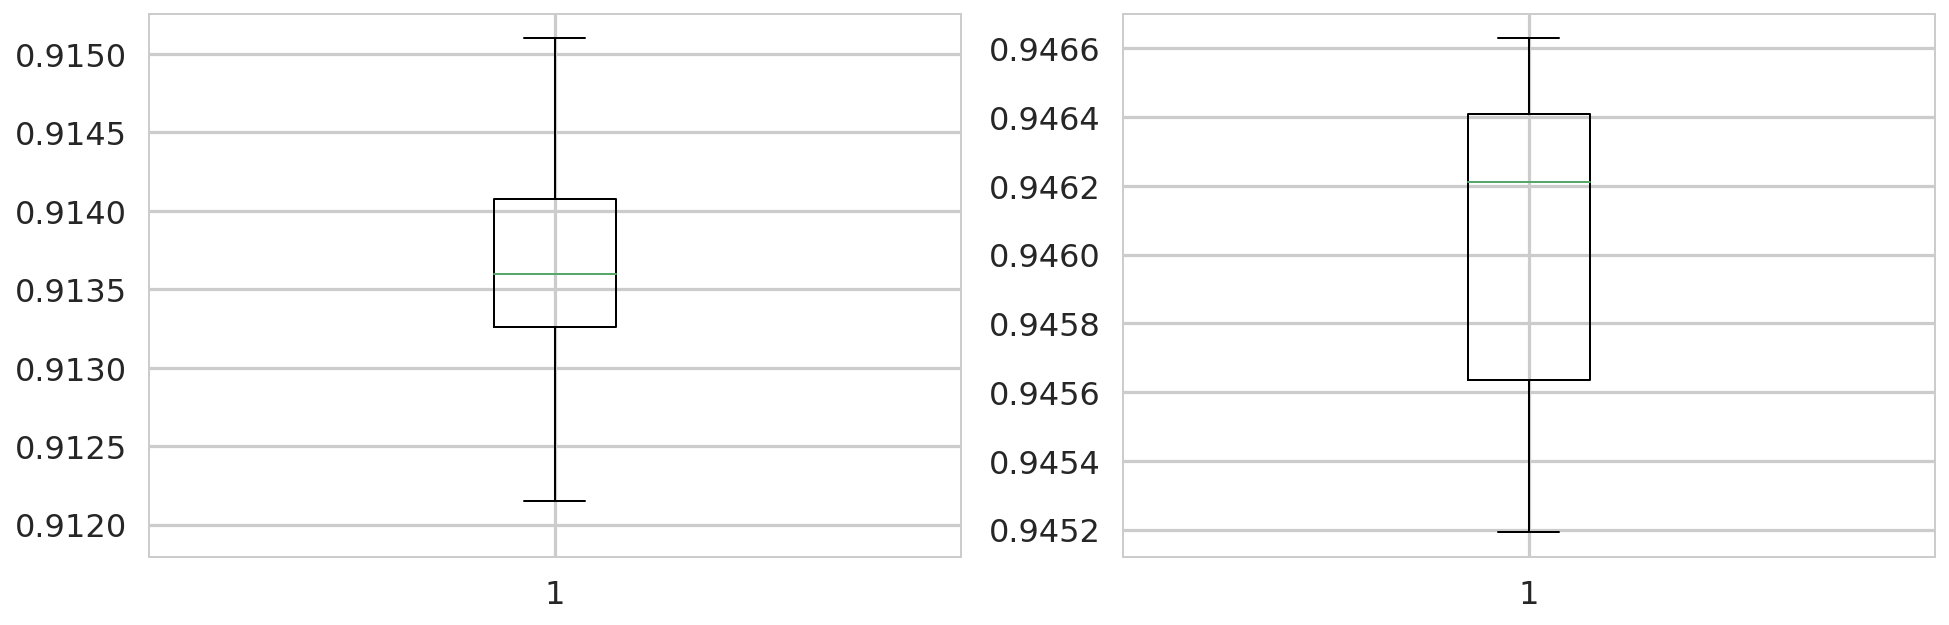

In [23]:
print('Mean validation accuracy: {}'.format(np.mean(discriminator_accuracies)))
print('Mean validation AUROC: {}'.format(np.mean(discriminator_aurocs)))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].boxplot(discriminator_accuracies)
axes[1].boxplot(discriminator_aurocs);

Visualize training loss for a single model and check for overfitting.

ACCURACY: 0.9177
AUROC: 0.9487
AVG PRECISION: 0.5867
CONFUSION MATRIX
[[0.864775  0.035225 ]
 [0.0470875 0.0529125]]
CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.95      0.96      0.95     72000
          1       0.60      0.53      0.56      8000

avg / total       0.91      0.92      0.92     80000



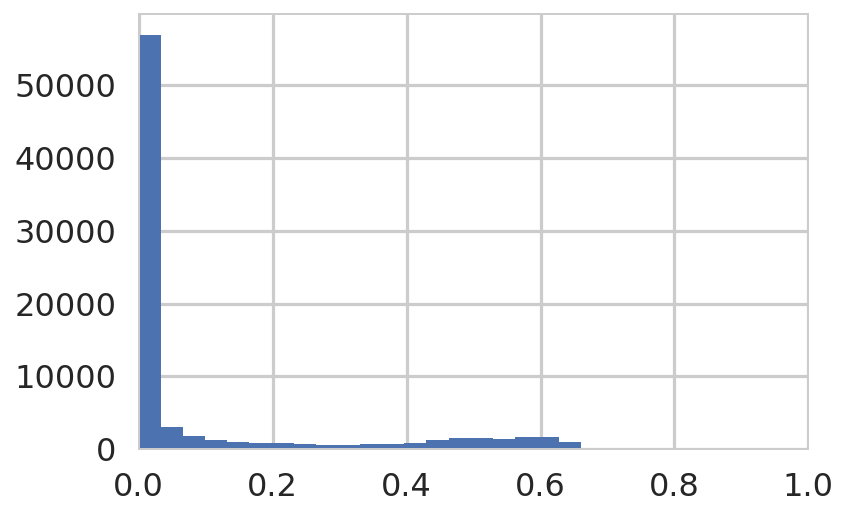

ACCURACY: 0.9137
AUROC: 0.9461
AVG PRECISION: 0.5620
CONFUSION MATRIX
[[0.86245 0.03755]
 [0.0487  0.0513 ]]
CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.95      0.96      0.95     18000
          1       0.58      0.51      0.54      2000

avg / total       0.91      0.91      0.91     20000



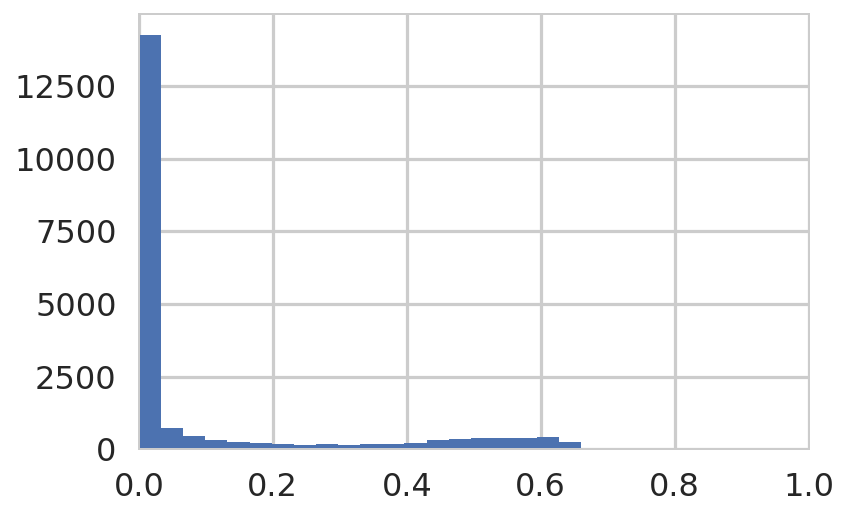

In [24]:
discriminator = make_dan()
discriminator.fit(X_train, y_train, batch_size=256, num_epochs=20, disguise=False)

y_train_preds = discriminator.predict(X_train)
y_test_preds = discriminator.predict(X_test)

evaluate_performance(y_train, y_train_preds)
evaluate_performance(y_test, y_test_preds)

# Test DAN performance
Now we train and evaluate the full DAN. 

In [25]:
dan_accuracies = list()
dan_aurocs = list()
for experiment in range(NUM_EXPERIMENTS):
  dan = make_dan()
  dan.fit(
    X_train, y_train, num_epochs=20, batch_size=256, disguise=True)
  accuracy = model_accuracy(dan, X_test, y_test)
  auroc = model_auroc(dan, X_test, y_test)
  dan_accuracies.append(accuracy)
  dan_aurocs.append(auroc)

Mean validation accuracy: 0.913105
Mean validation AUROC: 0.9452941118055556


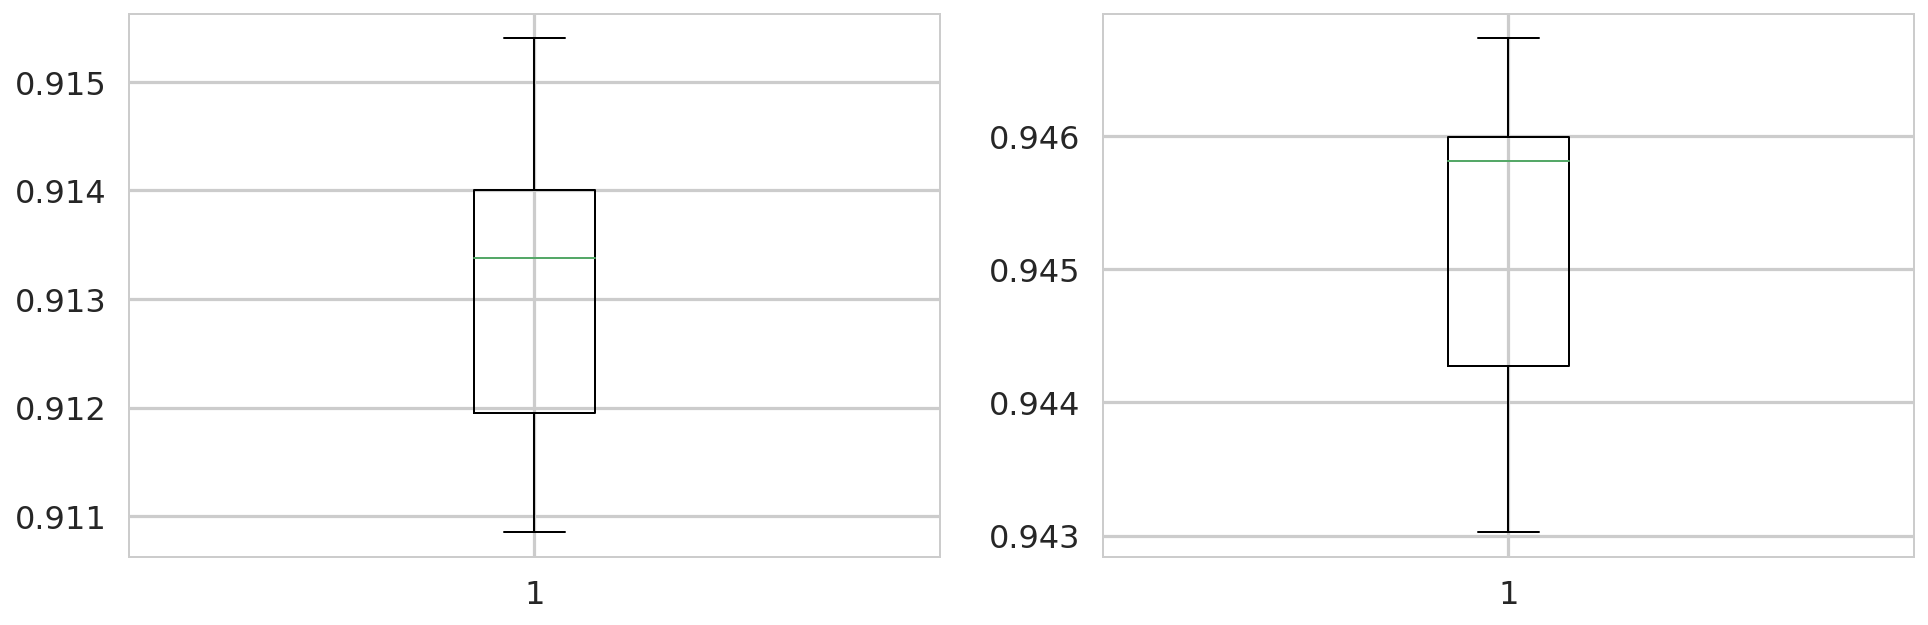

In [26]:
print('Mean validation accuracy: {}'.format(np.mean(dan_accuracies)))
print('Mean validation AUROC: {}'.format(np.mean(dan_aurocs)))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].boxplot(dan_accuracies)
axes[1].boxplot(dan_aurocs);

Check for overfitting.

ACCURACY: 0.9150
AUROC: 0.9451
AVG PRECISION: 0.5543
CONFUSION MATRIX
[[0.862675 0.037325]
 [0.047725 0.052275]]
CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.95      0.96      0.95     72000
          1       0.58      0.52      0.55      8000

avg / total       0.91      0.91      0.91     80000



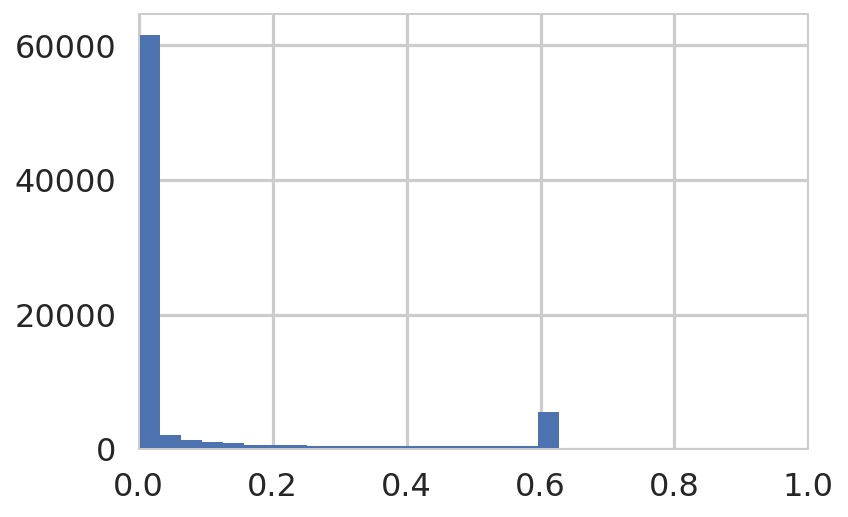

ACCURACY: 0.9097
AUROC: 0.9419
AVG PRECISION: 0.5311
CONFUSION MATRIX
[[0.85915 0.04085]
 [0.04945 0.05055]]
CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.95      0.95      0.95     18000
          1       0.55      0.51      0.53      2000

avg / total       0.91      0.91      0.91     20000



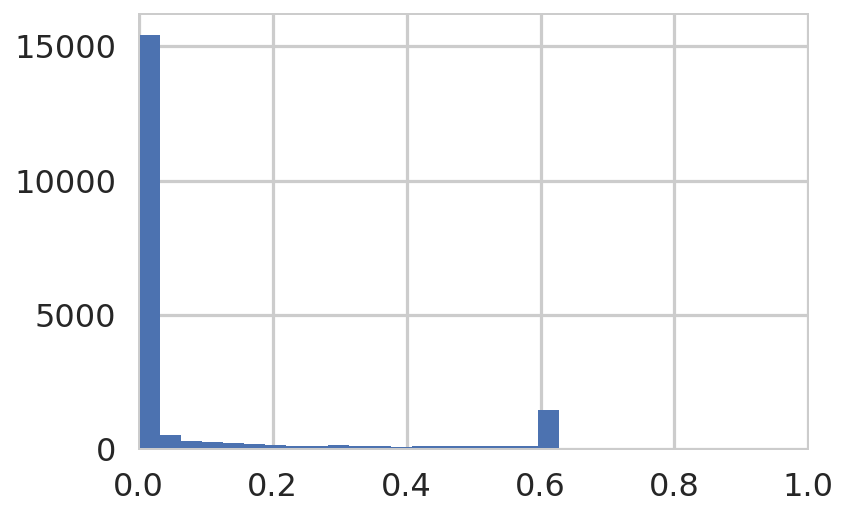

In [27]:
dan = make_dan()
dan.fit(X_train, y_train, batch_size=256, num_epochs=20, disguise=True)

y_train_preds = dan.predict(X_train)
y_test_preds = dan.predict(X_test)

evaluate_performance(y_train, y_train_preds)
evaluate_performance(y_test, y_test_preds)

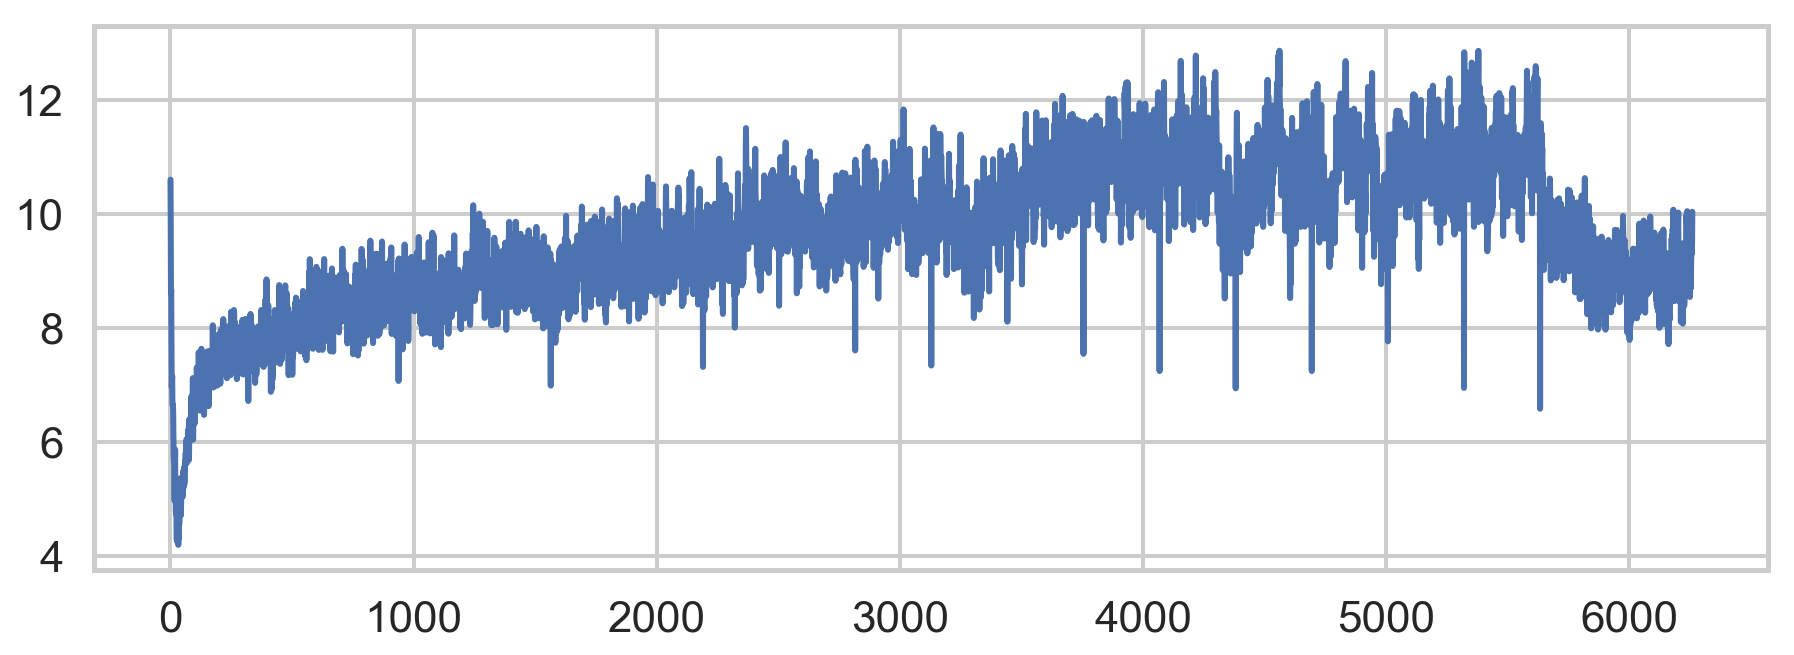

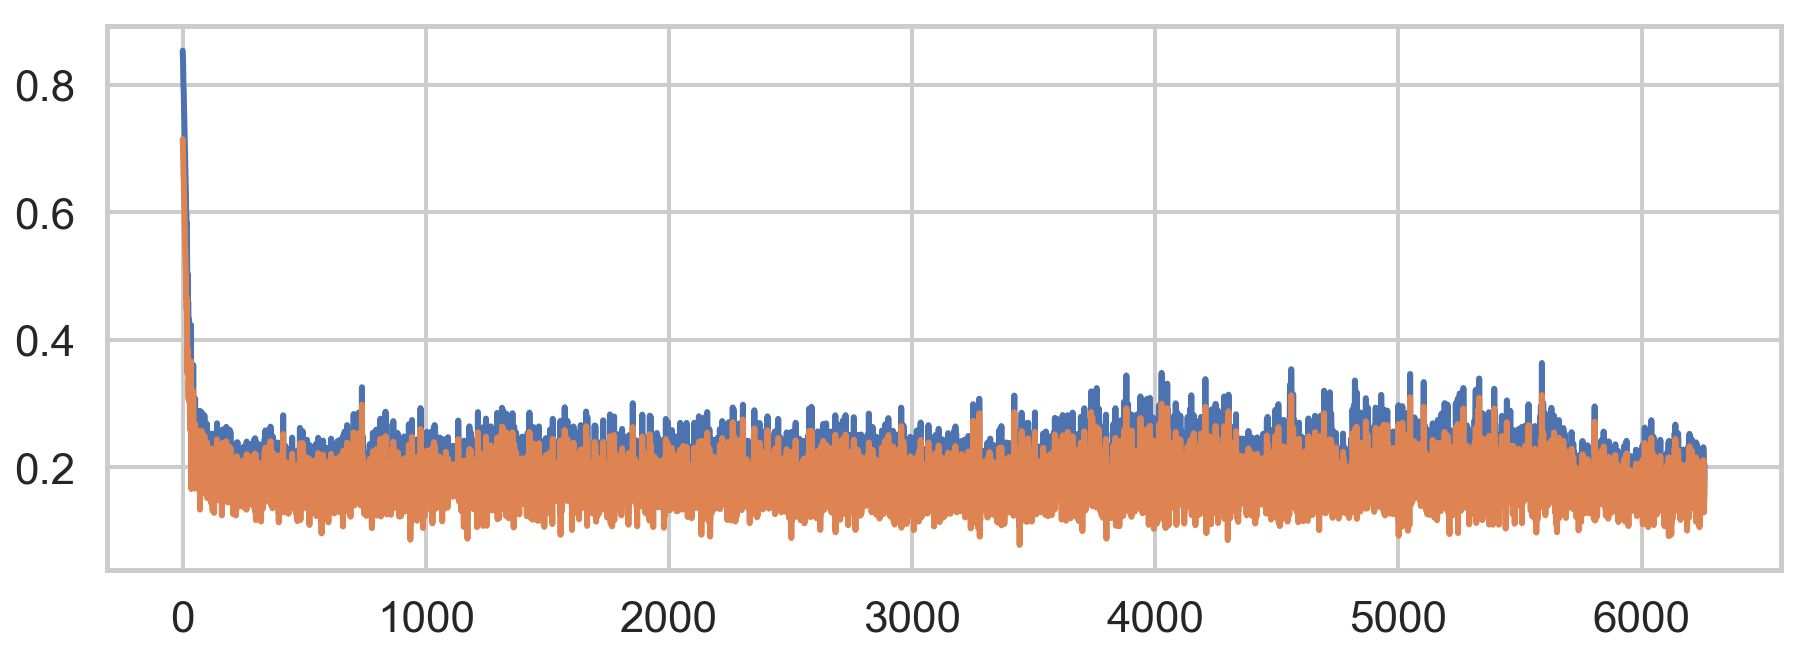

In [36]:
plt.figure(figsize=(15,5))
plt.plot(dan.history['disguise_loss'])
plt.show()

plt.figure(figsize=(15,5))
plt.plot(dan.history['discriminator_loss'])
plt.plot(dan.history['cross_entropy'])
plt.show()

# Compare model performance metrics

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a32775c18>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a32c41f28>], dtype=object)

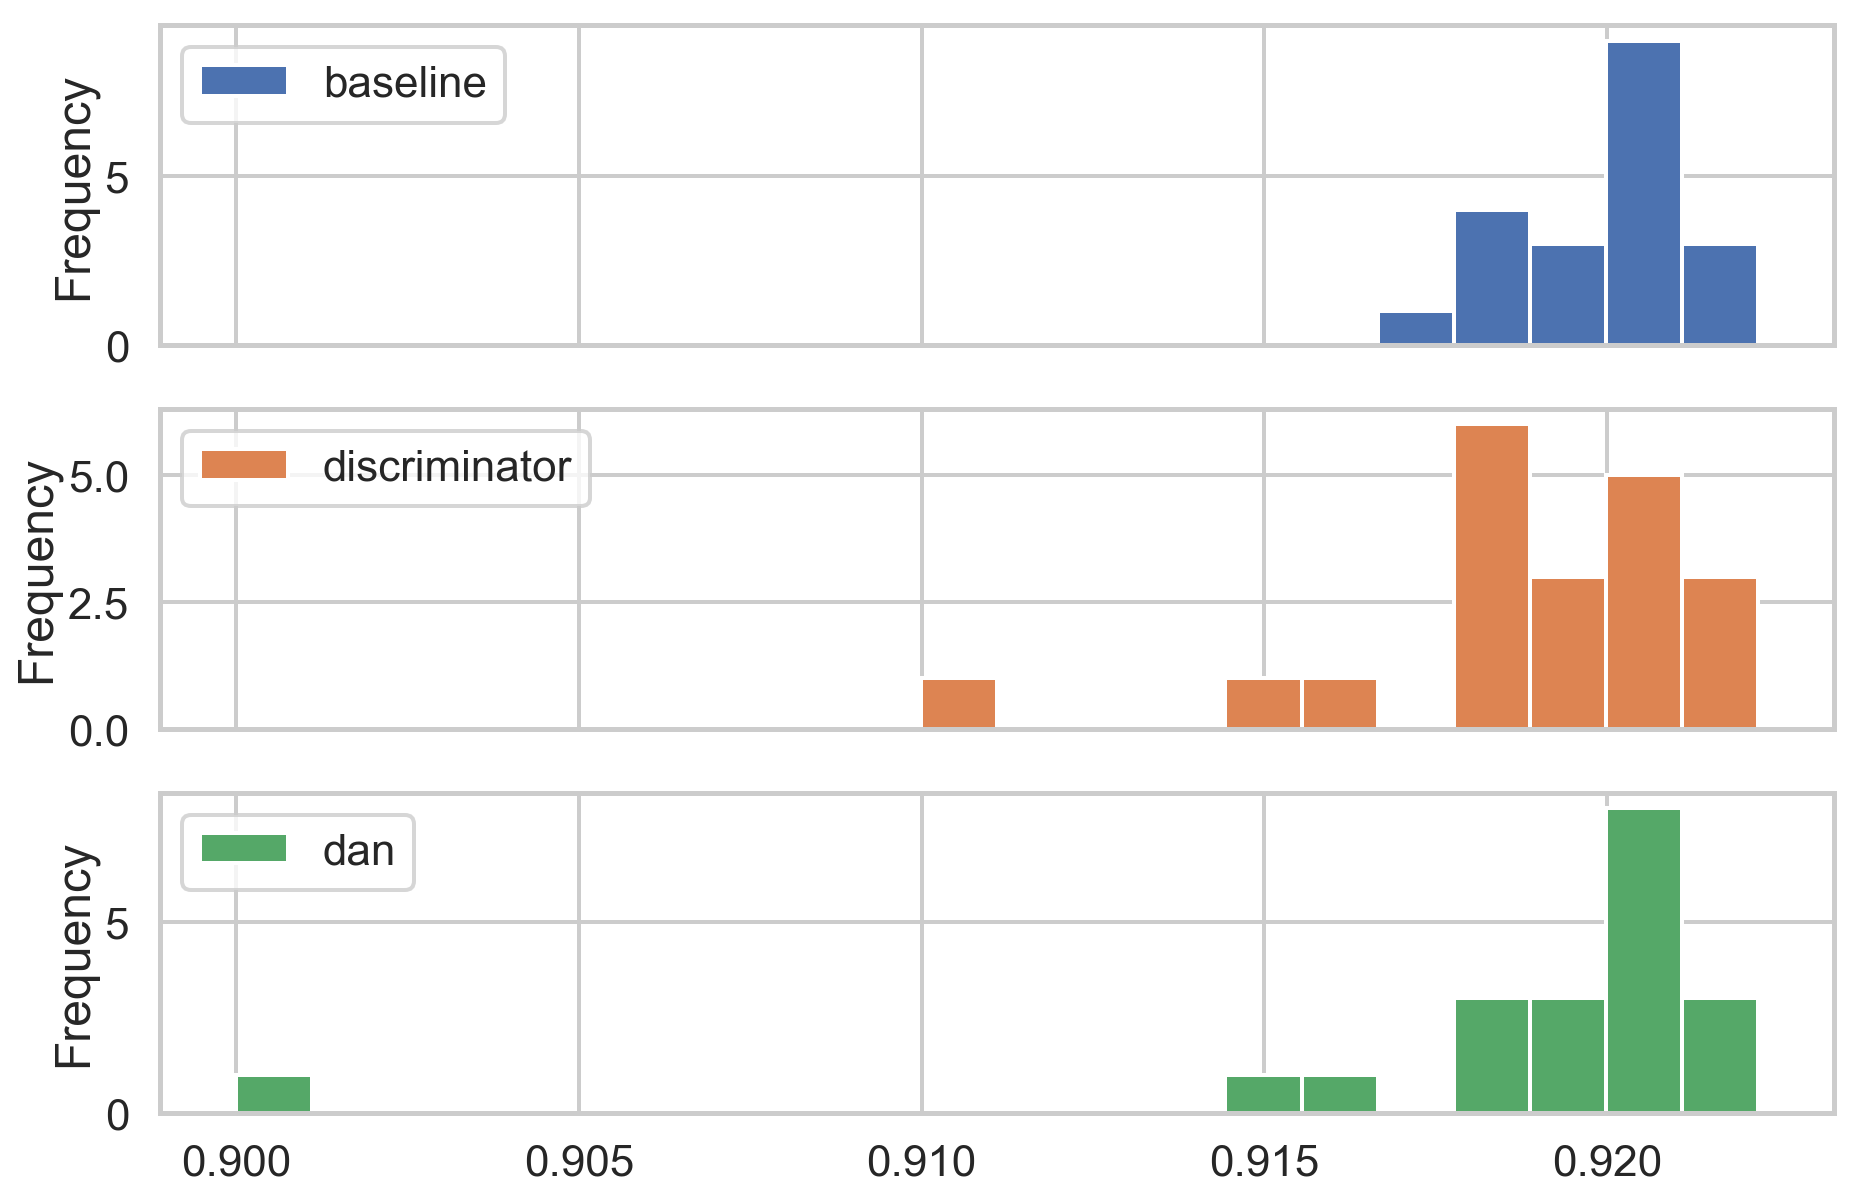

In [37]:
data = dict(
  baseline=baseline_accuracies,
  discriminator=discriminator_accuracies,
  dan=dan_accuracies,
)

accuracy_df = pd.DataFrame(data)
accuracy_df = accuracy_df[['baseline', 'discriminator', 'dan']]
accuracy_df.plot.hist(bins=20, subplots=True, figsize=(15,10))

[Text(0,0.5,'classification accuracy'),
 Text(0.5,0,'model'),
 Text(0.5,1,'accuracy distribution over 20 experiments')]

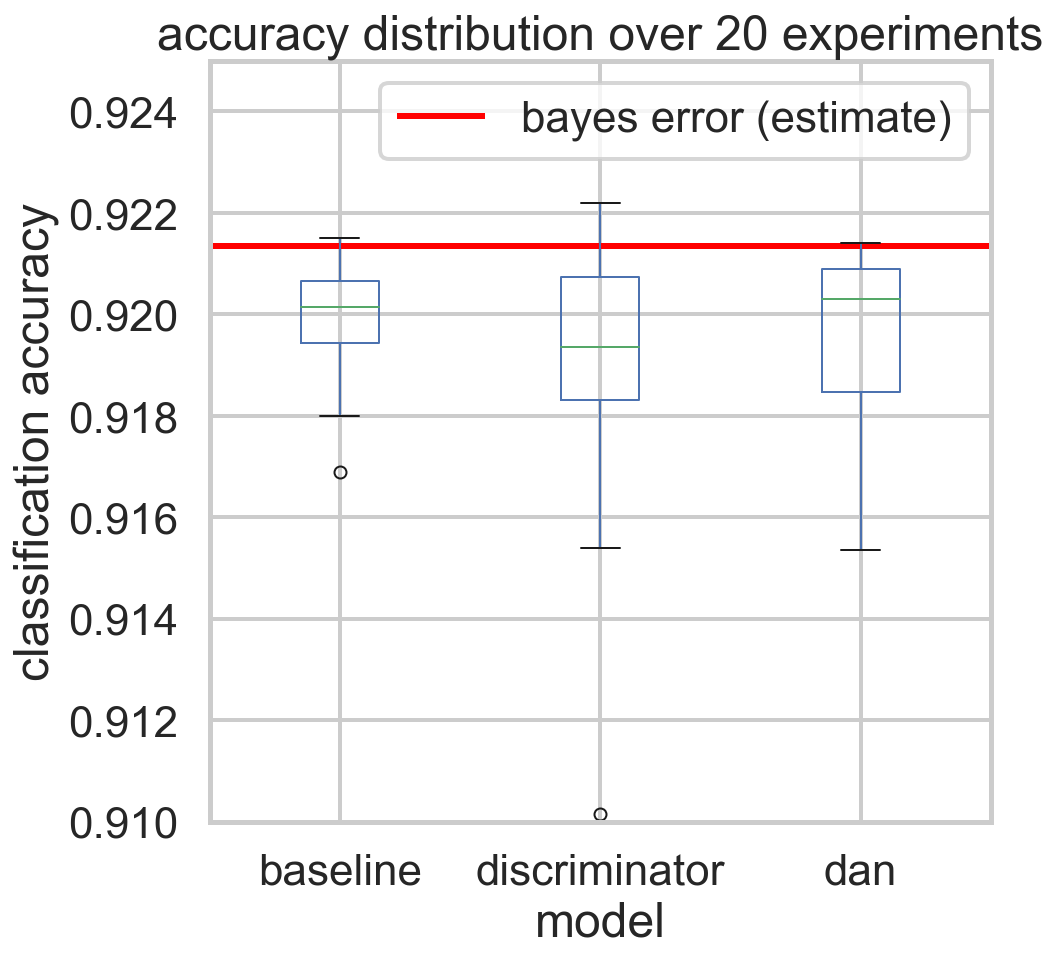

In [43]:
ax = accuracy_df.plot.box(figsize=(7, 7))
nb_accuracy = nb.score(X_test, y_test[:, 1])
ax.hlines(
  nb_accuracy, xmin=0, xmax=4, color='red', label='bayes error (estimate)')
ax.set_ylim(0.910, 0.925)
ax.legend()
ax.set(
  title=f'accuracy distribution over {NUM_EXPERIMENTS} experiments',
  xlabel='model',
  ylabel='classification accuracy'
)

# Examine disguise behavior

In [ ]:
for lambd in np.arange(0, 0.035, 0.005):
  tf.reset_default_graph()
  dan = DAN(
      checkpoint_dir='../models/dz-prototype/', num_features=NUM_FEATURES,
      lambd=lambd, eta=0.2, learning_rate=1e-2)
  dan.fit(X_train, y_train, batch_size=256, num_epochs=20, disguise=True)

  X_disguised = dan.transform(X_negatives)
  plt.figure(figsize=(15,15))
  ax = plt.gca()
  ax.scatter(
    X_negatives[:,0], X_negatives[:,1], c='gray', s=0.01, label='negatives')
  ax.scatter(
    X_positives[:,0], X_positives[:,1], c='yellow', s=0.01, label='positives')
  ax.scatter(
    X_disguised[:,0], X_disguised[:,1], c='purple', s=0.01, label='disguised')
  ax.set_title('activation=elu, $\lambda={:.3f}$'.format(lambd))

  neg = mlines.Line2D(
    [], [], color='gray', marker='o', linestyle='None', markersize=10, 
    label='negatives')
  pos = mlines.Line2D(
    [], [], color='yellow', marker='o', linestyle='None', markersize=10,
    label='postiives')
  dis = mlines.Line2D(
    [], [], color='purple', marker='o', linestyle='None', markersize=10,
    label='disguised')
  ax.legend(handles=[neg, pos, dis])
  plt.savefig('../reports/figures/2d-disguise-plots/elu-{:.3f}.png'.format(lambd))